flare                   0
start.date              0
start.time              0
peak                    0
end                     0
duration.s              0
peak.c/s                0
total.counts            0
energy.kev              0
x.pos.asec              0
y.pos.asec              0
radial                  0
active.region.ar        0
flag.1                  0
flag.2                  0
flag.3              19907
flag.4              20202
flag.5              61180
dtype: int64 flare                 int64
start.date           object
start.time           object
peak                 object
end                  object
duration.s            int64
peak.c/s              int64
total.counts        float64
energy.kev           object
x.pos.asec            int64
y.pos.asec            int64
radial                int64
active.region.ar      int64
flag.1               object
flag.2               object
flag.3               object
flag.4               object
flag.5               object
dtype: object
D

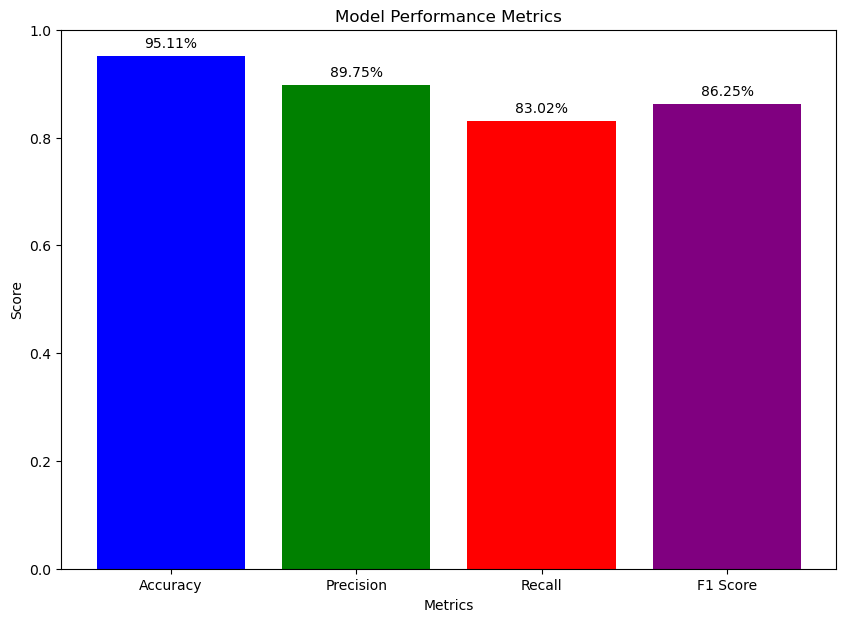

Model performance metrics bar plot saved to data/plots2/model_performance_metrics.png



Hypothetical Data Predictions:
   duration.s  total.counts  energy.kev  x.pos.asec  y.pos.asec  radial  \
0         300         10000          10         500        -300     600   
1         450        150000          20        -300         400     500   
2         600        250000          35         250        -150     700   
3         750         30000          40         300         200     800   
4         900         40000          45         400         600     900   
5        1005         70000          50        -600        -200    1000   

   active.region.ar  start.hour  start.weekday  peak.hour  ...  flag.2_GS  \
0              9811          10              2         10  ...          0   
1              9825          14              4         15  ...          0   
2              9830          16              5         17  ...          1   
3              9840          17              6         18  ...          0   
4              9850          18              8         20

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


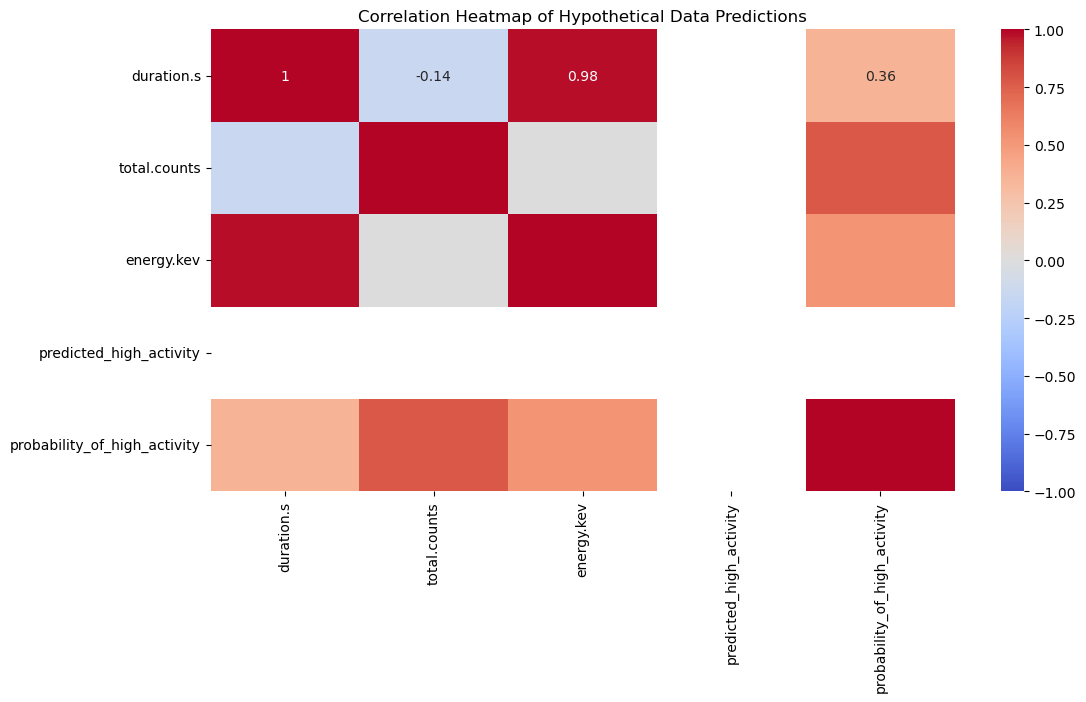

<Figure size 640x480 with 0 Axes>

In [2]:
# Imported libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Specify file path
file_path = 'hessi.solar.flare.UP_To_2018.csv'

# Read .csv file into a dataframe
solar_flare_data = pd.read_csv(file_path)

# Check for missing values and data types
missing_values = solar_flare_data.isnull().sum()
data_types = solar_flare_data.dtypes

# Print missing values and data types
print(missing_values, data_types)

# Filling missing values with 0
solar_flare_data = solar_flare_data.fillna(0)

print("DataFrame with Missing Values Filled:\n", solar_flare_data)

# Check for the presence of columns before attempting to drop them
columns_to_drop = ['flag.3', 'flag.4', 'flag.5']
columns_present = [col for col in columns_to_drop if col in solar_flare_data.columns]

# Drop columns if they are present
if columns_present:
    solar_flare_data = solar_flare_data.drop(columns=columns_present)

# Convert date and time columns to datetime objects
solar_flare_data['start.datetime'] = pd.to_datetime(solar_flare_data['start.date'] + ' ' + solar_flare_data['start.time'])
solar_flare_data['peak.datetime'] = pd.to_datetime(solar_flare_data['start.date'] + ' ' + solar_flare_data['peak'])
solar_flare_data['end.datetime'] = pd.to_datetime(solar_flare_data['start.date'] + ' ' + solar_flare_data['end'])
solar_flare_data = solar_flare_data.drop(columns=['start.date', 'start.time', 'peak', 'end'])

# Convert energy.kev to numerical ranges (midpoints) 
def energy_to_midpoint(energy_str):
    low, high = map(int, energy_str.split('-'))
    return (low + high) / 2

solar_flare_data['energy.kev'] = solar_flare_data['energy.kev'].apply(energy_to_midpoint)

# Extract features from datetime columns
solar_flare_data['start.hour'] = solar_flare_data['start.datetime'].dt.hour
solar_flare_data['start.weekday'] = solar_flare_data['start.datetime'].dt.weekday
solar_flare_data['peak.hour'] = solar_flare_data['peak.datetime'].dt.hour
solar_flare_data['peak.weekday'] = solar_flare_data['peak.datetime'].dt.weekday
solar_flare_data['end.hour'] = solar_flare_data['end.datetime'].dt.hour
solar_flare_data['end.weekday'] = solar_flare_data['end.datetime'].dt.weekday
solar_flare_data = solar_flare_data.drop(columns=['start.datetime', 'peak.datetime', 'end.datetime'])

# Define the target variable
threshold = 215
solar_flare_data['high_activity'] = (solar_flare_data['peak.c/s'] >= threshold).astype(int)

# Split the data into features and target
X = solar_flare_data.drop(columns=['flare', 'peak.c/s', 'high_activity'])
y = solar_flare_data['high_activity']

# Perform one-hot encoding on categorical columns
X_encoded = pd.get_dummies(X, columns=['flag.1', 'flag.2'])

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Print the results
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")
print("Classification Report:\n", classification_rep)

# Create a bar plot for accuracy, precision, recall, and F1 score
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

plt.figure(figsize=(10, 7))
plt.bar(metric_names, metric_values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')

# Assign bars with metric values
for i, value in enumerate(metric_values):
    plt.text(i, value + 0.01, f"{value:.2%}", ha='center', va='bottom')

# Save the plot
plots_dir = 'data/plots2'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

plot_path = os.path.join(plots_dir, 'model_performance_metrics.png')
plt.savefig(plot_path)
plt.show()

print(f"Model performance metrics bar plot saved to {plot_path}")

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Activity', 'High Activity'], yticklabels=['Low Activity', 'High Activity'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the plot
plot_path = os.path.join(plots_dir, 'confusion_matrix_heatmap.png')
plt.savefig(plot_path)
plt.show()

# Hypothetical data for prediction
hypothetical_data = {
    'duration.s': [300, 450, 600, 750, 900, 1005],
    'total.counts': [10000, 150000, 250000, 30000, 40000, 70000],
    'energy.kev': [10, 20, 35, 40, 45, 50],
    'x.pos.asec': [500, -300, 250, 300, 400, -600],
    'y.pos.asec': [-300, 400, -150, 200, 600, -200],
    'radial': [600, 500, 700, 800, 900, 1000],
    'active.region.ar': [9811, 9825, 9830, 9840, 9850, 9860],
    'flag.1_A0': [1, 0, 0, 1, 0, 0],
    'flag.1_A1': [0, 1, 1, 0, 1, 0],
    'flag.2_GS': [0, 0, 1, 0, 1, 0],
    'flag.2_P1': [1, 1, 0, 1, 0, 0],
    'start.hour': [10, 14, 16, 17, 18, 19],
    'start.weekday': [2, 4, 5, 6, 8, 9],
    'peak.hour': [10, 15, 17, 18, 20, 22],
    'peak.weekday': [2, 4, 5, 6, 8, 9],
    'end.hour': [11, 16, 18, 20, 21, 24],
    'end.weekday': [2, 4, 5, 6, 8, 9]
}

hypothetical_df = pd.DataFrame(hypothetical_data)

# Align columns with the training data
X_encoded_columns = X_encoded.columns.tolist()
missing_columns = set(X_encoded_columns) - set(hypothetical_df.columns)
for col in missing_columns:
    hypothetical_df[col] = 0

# Reorder columns to match the training data
hypothetical_df = hypothetical_df[X_encoded_columns]

# Scale the hypothetical data
hypothetical_df_scaled = scaler.transform(hypothetical_df)

# Predict using the trained model
predictions = rf_model.predict(hypothetical_df_scaled)
prediction_probabilities = rf_model.predict_proba(hypothetical_df_scaled)[:, 1]

# Combine the hypothetical data with predictions and probabilities
hypothetical_df['predicted_high_activity'] = predictions
hypothetical_df['probability_of_high_activity'] = prediction_probabilities

print("\nHypothetical Data Predictions:")
print(hypothetical_df)

# Create a DataFrame for the heatmap
heatmap_data = hypothetical_df[['duration.s', 'total.counts', 'energy.kev', 'predicted_high_activity', 'probability_of_high_activity']]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Hypothetical Data Predictions')
plt.show()

# Save the plot
plot_path = os.path.join(plots_dir, 'Hypotheticals.png')
plt.savefig(plot_path)
plt.show()
